In [26]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import chi2_contingency
import seaborn as sns
import numpy as np
from scipy.cluster.hierarchy import linkage

Part 1

In [27]:
# Load the TSV file
expression_path = 'ERP009868.tsv'
expression_data = pd.read_csv(expression_path, sep='\t', index_col=0)

# Load your metadata (assuming it's also a CSV file)
metadata_path = 'metadata_ERP009868.tsv'
metadata = pd.read_csv(metadata_path, sep='\t', index_col=0)


In [28]:
expression_data = expression_data.T

Part 2a

In [29]:
# Calculate variance for each gene
variances = expression_data.var(axis=0)

# Get the indices of the 5,000 most variable genes
top_genes = variances.nlargest(5000).index
print(top_genes.shape)

# Subset the expression data
subset_expression_data = expression_data[top_genes]
print(subset_expression_data.shape)


(5000,)
(1886, 5000)


In [30]:
# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(subset_expression_data)
print("Shape of scaled data:", scaled_data.shape)


Shape of scaled data: (1886, 5000)


In [31]:
# Standardize the data
print("Shape of scaled data:", scaled_data.shape)
print("Shape of metadata:", metadata.shape)


Shape of scaled data: (1886, 5000)
Shape of metadata: (1886, 23)


Part 2b

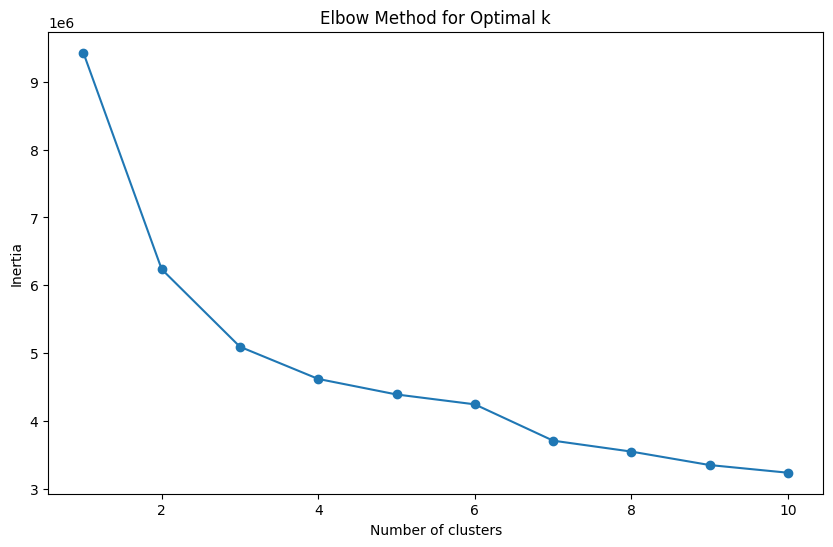

                         experiment_accession  refinebio_age  \
refinebio_accession_code                                       
ERR1046065                          ERP009868            NaN   
ERR1046066                          ERP009868            NaN   
ERR1046067                          ERP009868            NaN   
ERR1046068                          ERP009868            NaN   
ERR1046069                          ERP009868            NaN   

                          refinebio_cell_line  refinebio_compound  \
refinebio_accession_code                                            
ERR1046065                                NaN                 NaN   
ERR1046066                                NaN                 NaN   
ERR1046067                                NaN                 NaN   
ERR1046068                                NaN                 NaN   
ERR1046069                                NaN                 NaN   

                          refinebio_developmental_stage  refinebio_

In [32]:
# Determine the optimal number of clusters (optional but recommended)
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

# Fit K-means with a chosen number of clusters
n_clusters = 5  # Choose the optimal number from the elbow plot
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_data)

# Add cluster labels to the metadata
metadata['Clusters'] = cluster_labels

# Save the updated metadata to a file
metadata.to_csv('kmeans_metadata_ERP009868.tsv', sep='\t')

print(metadata.head())


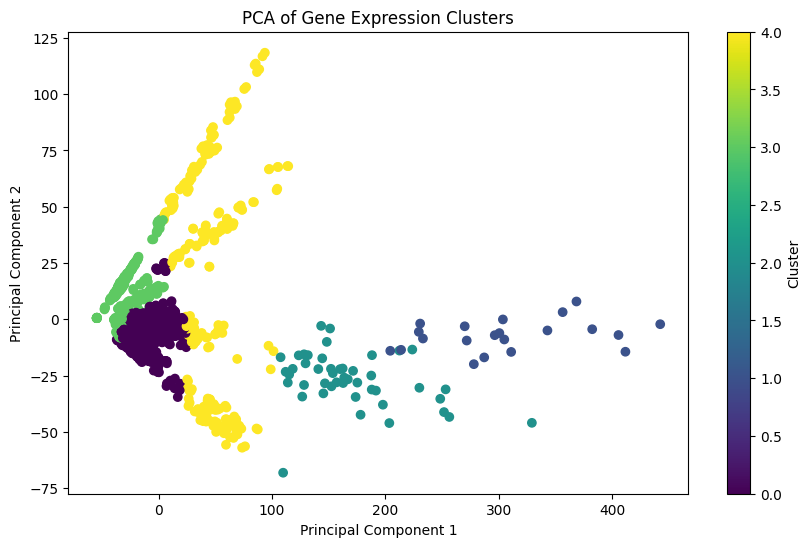

In [33]:
# Perform PCA for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)


# Step 3: Shift data to avoid negative values before applying log2
shift_value = np.abs(np.min(pca_result)) + 1  # Shift data to make all values positive
pca_data_shifted = pca_result + shift_value

# Log2 transformation of the PCA-reduced, shifted data
pca_data_log2 = np.log2(pca_data_shifted)

# Create a DataFrame for PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['Cluster'] = cluster_labels

# Plot PCA results
plt.figure(figsize=(10, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Cluster'], cmap='viridis')
plt.title('PCA of Gene Expression Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()


Part 2d

In [34]:
# Number of clusters
n_clusters = len(set(cluster_labels))
print(f"Number of clusters found: {n_clusters}")

# Count of samples in each cluster
cluster_counts = pd.Series(cluster_labels).value_counts()
print(cluster_counts)


Number of clusters found: 5
0    1105
3     435
4     279
2      46
1      21
Name: count, dtype: int64


In [35]:
# Run K-means for different k values
k_values = [2, 3, 4, 5, 6]  # Example values
results = {}

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_data)
    results[k] = cluster_labels

# Compare cluster membership
for k, labels in results.items():
    print(f"Cluster labels for k={k}:")
    print(pd.Series(labels).value_counts())


Cluster labels for k=2:
0    1816
1      70
Name: count, dtype: int64
Cluster labels for k=3:
0    1527
2     304
1      55
Name: count, dtype: int64
Cluster labels for k=4:
0    1508
3     311
2      46
1      21
Name: count, dtype: int64
Cluster labels for k=5:
0    1105
3     435
4     279
2      46
1      21
Name: count, dtype: int64
Cluster labels for k=6:
0    1103
3     435
4     276
2      34
1      20
5      18
Name: count, dtype: int64


Part 2e

In [36]:
gene_counts = [10, 100, 1000, 10000]
clustering_results = {}

for n_genes in gene_counts:
    top_genes = variances.nlargest(n_genes).index
    subset_expression_data = expression_data[top_genes]
    scaled_data = scaler.fit_transform(subset_expression_data)
    
    # Fit K-means (for example) with a chosen k
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_data)
    clustering_results[n_genes] = cluster_labels
    


In [37]:
chi2_results = []

for n_genes_1 in gene_counts:
    for n_genes_2 in gene_counts:
        if n_genes_1 < n_genes_2:
            contingency_table = pd.crosstab(
                clustering_results[n_genes_1],
                clustering_results[n_genes_2]
            )
            chi2, p, _, _ = chi2_contingency(contingency_table)
            chi2_results.append((n_genes_1, n_genes_2, chi2, p))

# Convert results to DataFrame for better presentation
chi2_df = pd.DataFrame(chi2_results, columns=['Gene Count 1', 'Gene Count 2', 'Chi-squared', 'p-value'])
print(chi2_df)


   Gene Count 1  Gene Count 2  Chi-squared  p-value
0            10           100  2472.721648      0.0
1            10          1000  2440.710549      0.0
2            10         10000  2525.547368      0.0
3           100          1000  5471.615391      0.0
4           100         10000  4550.505371      0.0
5          1000         10000  5096.218646      0.0


In [38]:
import plotly.graph_objects as go

# Prepare data for the Sankey diagram
labels = []
for n_genes in gene_counts:
    for cluster_num in range(n_clusters):
        labels.append(f'Cluster {cluster_num} ({n_genes} genes)')

source = []  # Source nodes
target = []  # Target nodes
value = []   # Values (number of samples moving between clusters)

# Create contingency tables and fill in source, target, and value
for i, n_genes_1 in enumerate(gene_counts):
    for j, n_genes_2 in enumerate(gene_counts):
        if i < j:
            contingency_table = pd.crosstab(
                clustering_results[n_genes_1],
                clustering_results[n_genes_2]
            )
            # Populate source, target, and value
            for k in range(contingency_table.shape[0]):  # Rows from first result
                for l in range(contingency_table.shape[1]):  # Columns from second result
                    if contingency_table.iat[k, l] > 0:
                        source.append(k + i * n_clusters)  # Offset by cluster index for first gene count
                        target.append(l + j * n_clusters)  # Offset by cluster index for second gene count
                        value.append(contingency_table.iat[k, l])  # The number of samples

# Create the Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels
    ),
    link=dict(
        source=source,
        target=target,
        value=value
    )
))

fig.update_layout(title_text="Alluvial Diagram of Cluster Memberships", font_size=10)
fig.show()

Part 3

In [39]:
# Create a new column for sample groups based on refinebio_title
metadata['Sample_Group'] = metadata['refinebio_title'].apply(lambda x: 'Reference' if x == 'Danio rerio' else 'Mutant')

# Create a DataFrame for annotations
annotations = pd.DataFrame({
    'Sample Group': metadata['Sample_Group'],  # Replace with your actual column name
    'KMeans': metadata['Clusters'],  # Adjust according to your clustering results
    # Add other clustering method results here, e.g. Gaussian Mixture, etc.
})

# Ensure annotations are aligned with the expression data
annotations = annotations.loc[subset_expression_data.index]


c:\Python312\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

C:\Users\david\AppData\Roaming\Python\Python312\site-packages\seaborn\matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.

C:\Users\david\AppData\Roaming\Python\Python312\site-packages\seaborn\matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.

C:\Users\david\AppData\Local\Temp\ipykernel_27856\957369341.py:99: UserWarning:

Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.



<Figure size 1500x1000 with 0 Axes>

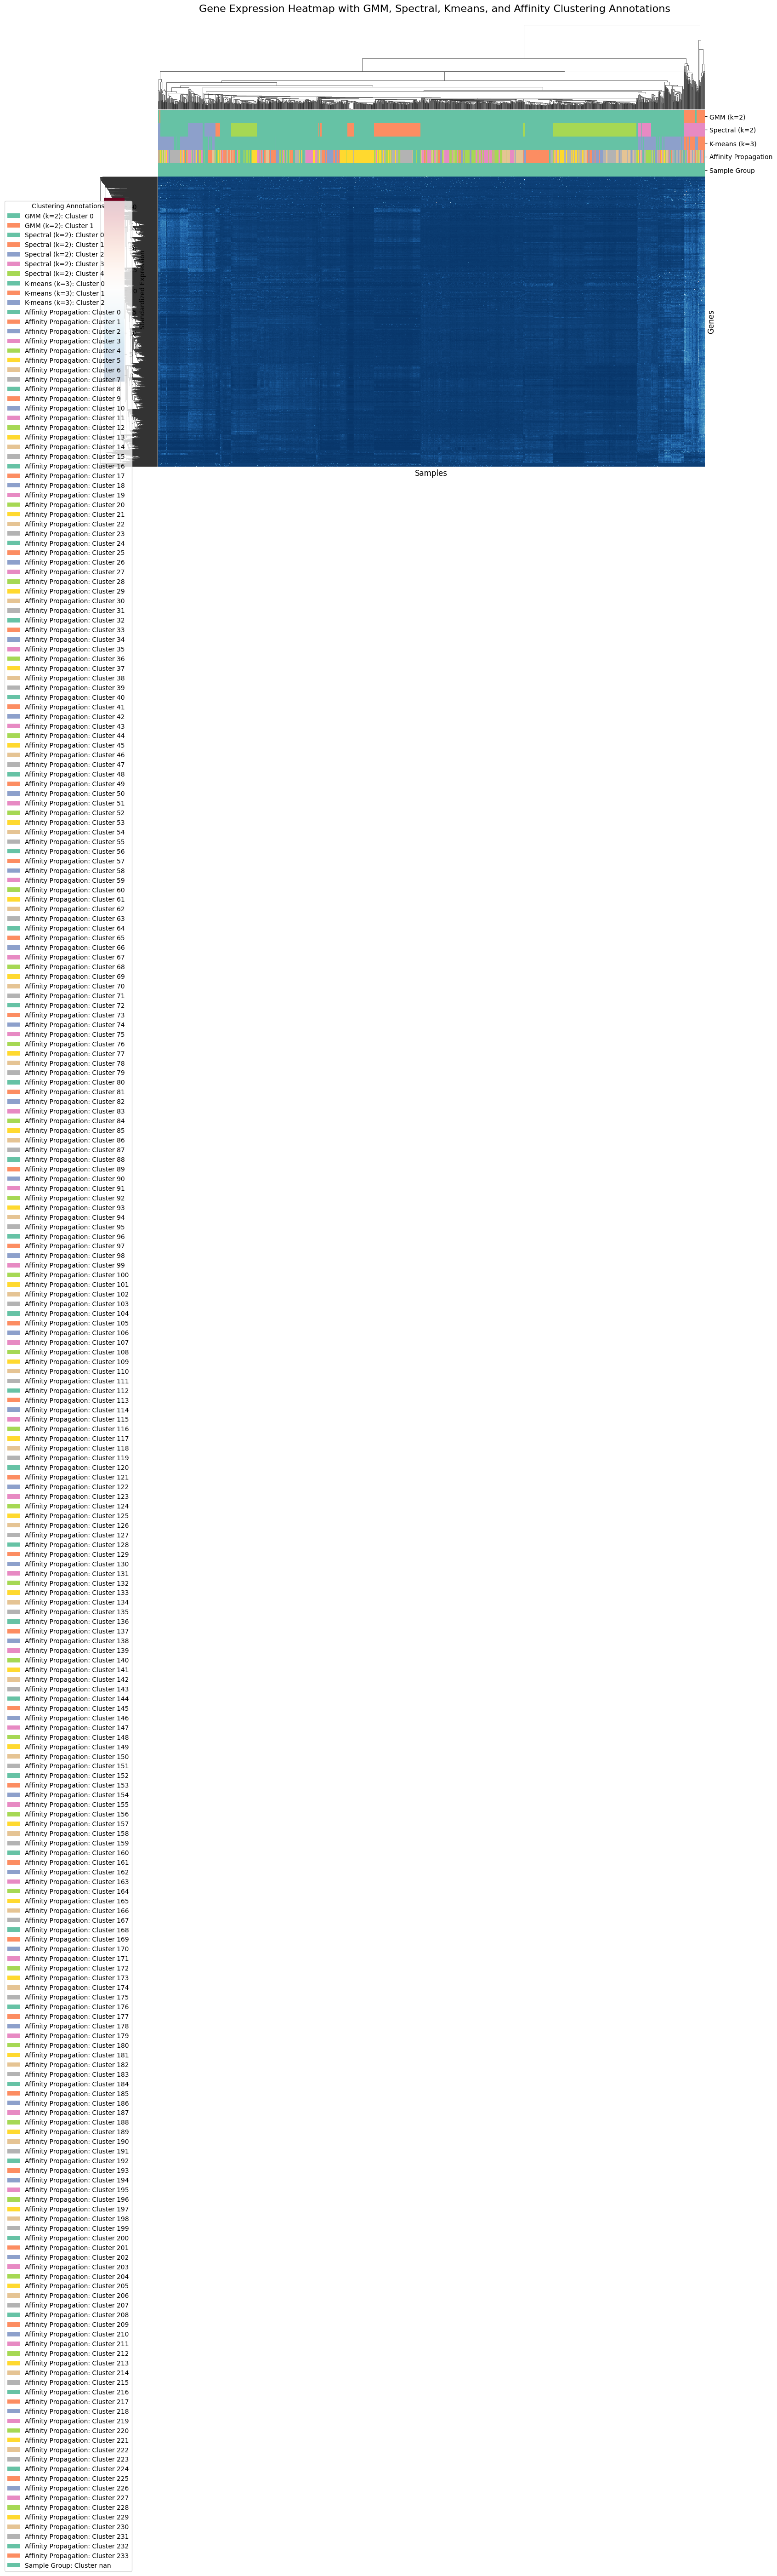

In [49]:
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import AffinityPropagation


# Get the 5,000 most variable genes
var_genes = expression_data.std(axis=1).sort_values(ascending=False).head(5000).index
expression_subset = expression_data.loc[var_genes]

# Scale the data for better visualization
scaler = StandardScaler()
expression_scaled = pd.DataFrame(
    scaler.fit_transform(expression_subset.T).T,  # Scale the data
    index=expression_subset.index,
    columns=expression_subset.columns
)

# Create annotation DataFrame
annotations = pd.DataFrame(index=expression_subset.columns)

# Add GMM clustering results (2 clusters)
gmm = GaussianMixture(n_components=2, random_state=42)
gmm_labels = gmm.fit_predict(expression_scaled.T)
annotations['GMM (k=2)'] = gmm_labels

# Add Spectral Clustering (5 clusters)
spectral = SpectralClustering(n_clusters=5, affinity='nearest_neighbors', random_state=42)
spectral_labels = spectral.fit_predict(expression_scaled.T)
annotations['Spectral (k=2)'] = spectral_labels

# Add K-means clustering results (e.g., 3 clusters)
kmeans = KMeans(n_clusters=3, random_state=42)  # Adjust n_clusters as needed
kmeans_labels = kmeans.fit_predict(expression_scaled.T)
annotations['K-means (k=3)'] = kmeans_labels  # Add K-means labels to annotations

# Add Affinity Propagation Clustering (Dimitri's method)
affinity = AffinityPropagation(damping=0.9, random_state=42)
affinity_labels = affinity.fit_predict(expression_scaled.T)
annotations['Affinity Propagation'] = affinity_labels

# Add sample groups as an annotation column
annotations['Sample Group'] = metadata['Sample_Group']  # Replace with the correct column name if needed

# Create a color mapping for the clusters
cluster_colors = sns.color_palette("Set2", n_colors=3)  # We can use up to 3 colors
annotation_colors = {}

for column in annotations.columns:
    unique_values = sorted(annotations[column].unique())
    annotation_colors[column] = dict(zip(unique_values, sns.color_palette("Set2", len(unique_values))))

# Create the colors for the annotations (row colors for heatmap)
col_colors = annotations.apply(lambda x: x.map(annotation_colors[x.name]))

# Create the clustermap with both GMM and Spectral clustering results
plt.figure(figsize=(15, 10))
clustermap = sns.clustermap(
    expression_scaled,  # Scaled data
    cmap='RdBu_r',  # Red-Blue color map
    col_colors=col_colors,  # Annotations on top of the columns
    dendrogram_ratio=(.1, .2),  # Adjust size of the dendrograms
    cbar_pos=(0.02, .2, .03, .4),  # Color bar position
    row_cluster=True,  # Cluster rows (genes)
    col_cluster=True,  # Cluster columns (samples)
    xticklabels=False,  # Don't show sample labels on heatmap
    yticklabels=False,  # Don't show gene labels
    figsize=(15, 10)  # Set figure size
)

# Add titles and labels
plt.suptitle('Gene Expression Heatmap with GMM, Spectral, Kmeans, and Affinity Clustering Annotations', y=1.02, size=16)
clustermap.ax_heatmap.set_xlabel('Samples', size=12)
clustermap.ax_heatmap.set_ylabel('Genes', size=12)

# Adjust colorbar label
clustermap.ax_cbar.set_ylabel('Standardized Expression', size=10)

# Create custom legend for annotations
legend_elements = []
for column in annotations.columns:
    unique_values = sorted(annotations[column].unique())
    for value in unique_values:
        legend_elements.append(
            plt.Rectangle((0, 0), 1, 1, 
                          fc=annotation_colors[column][value],
                          label=f'{column}: Cluster {value}')
        )

# Add legend
plt.legend(handles=legend_elements, 
           title='Clustering Annotations',
           bbox_to_anchor=(1.5, 1),
           loc='upper right')

plt.tight_layout()
plt.show()


Contingency Table for KMeans k=2:
KMeans k=2          0   1
Mutation Status          
mutated           432   5
non-mutated      1384  65

Contingency Table for KMeans k=5:
KMeans k=5         0   1   2    3    4
Mutation Status                       
mutated          420   0   5   12    0
non-mutated      685  21  41  423  279

Contingency Table for KMeans k=10:
KMeans k=10        0   1   2   3   4   5    6   7    8    9
Mutation Status                                            
mutated           21   5   0   0   0   0   33   0   10  368
non-mutated      436  37  90  11  72  88  216  13  395   91

Chi-squared Test Results:
                            Test  Chi-Square Statistic       P-value  Degrees of Freedom  Adjusted P-value (FDR)
 KMeans (k=2) vs Mutation Status              9.576601  1.970729e-03                   1            1.970729e-03
 KMeans (k=5) vs Mutation Status            332.865661  8.769618e-71                   4            1.315443e-70
KMeans (k=10) vs Mutation St

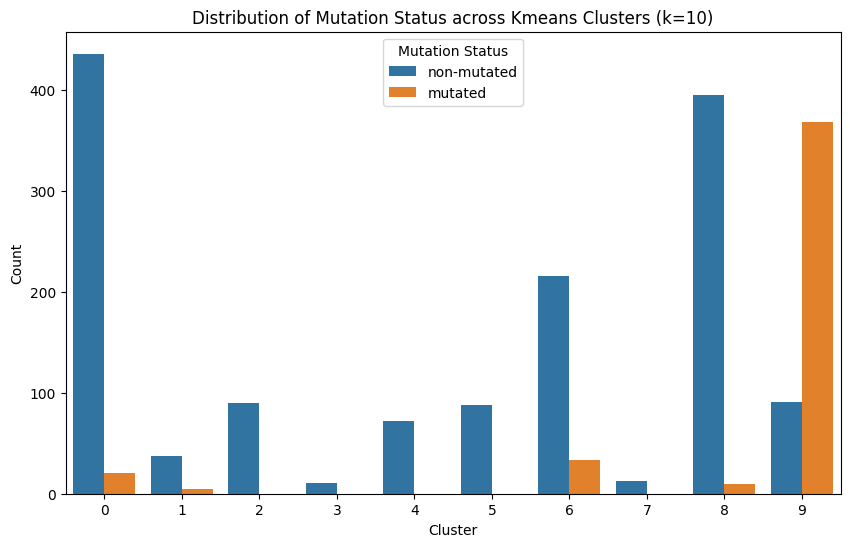

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency
from statsmodels.stats.multitest import multipletests

# Create mutation status mapping based on sample IDs
def create_mutation_status(sample_ids):
    mutation_status = []
    for sample in sample_ids:
        if isinstance(sample, str) and sample.startswith("ERR"):
            # Extract just the numeric part, removing any empty strings
            try:
                # Remove any non-numeric characters after ERR
                numeric_part = ''.join(filter(str.isdigit, sample[3:]))
                if numeric_part and int(numeric_part) < 1046070:
                    mutation_status.append("mutated")
                else:
                    mutation_status.append("non-mutated")
            except ValueError:
                mutation_status.append("non-mutated")
        else:
            mutation_status.append("non-mutated")
    return mutation_status

# Get the clustering results using KMeans
def perform_chi_squared_tests(expression_data, n_clusters_list=[2, 5, 10]):
    results = []
    
    # Get mutation status for samples
    mutation_status = create_mutation_status(expression_data.columns)
    
    # For each number of clusters
    for n_clusters in n_clusters_list:
        # Perform KMeans Clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        
        # Get the 5,000 most variable genes
        var_genes = expression_data.std(axis=1).sort_values(ascending=False).head(5000).index
        expression_subset = expression_data.loc[var_genes]
        
        # Scale the data
        scaler = StandardScaler()
        expression_scaled = scaler.fit_transform(expression_subset.T)
        
        # Get cluster assignments
        cluster_labels = kmeans.fit_predict(expression_scaled)
        
        # Create contingency table
        contingency_table = pd.crosstab(
            pd.Series(mutation_status, name='Mutation Status'),
            pd.Series(cluster_labels, name=f'KMeans k={n_clusters}')
        )
        
        # Perform chi-squared test
        chi2, pval, dof, expected = chi2_contingency(contingency_table)
        
        # Store results
        results.append({
            'Test': f'KMeans (k={n_clusters}) vs Mutation Status',
            'Chi-Square Statistic': chi2,
            'P-value': pval,
            'Degrees of Freedom': dof
        })
        
        # Print contingency table for inspection
        print(f"\nContingency Table for KMeans k={n_clusters}:")
        print(contingency_table)
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Adjust p-values for multiple testing
    results_df['Adjusted P-value (FDR)'] = multipletests(
        results_df['P-value'], 
        method='fdr_bh'  # Benjamini-Hochberg procedure
    )[1]
    
    return results_df

# Run the analysis
results = perform_chi_squared_tests(expression_data)

# Display results
print("\nChi-squared Test Results:")
print(results.to_string(index=False))

# Create a more detailed visualization of the relationships
plt.figure(figsize=(10, 6))

# For k=5 clustering
kmeans2 = KMeans(n_clusters=10, random_state=42)
var_genes = expression_data.std(axis=1).sort_values(ascending=False).head(5000).index
expression_subset = expression_data.loc[var_genes]
scaler = StandardScaler()
expression_scaled = scaler.fit_transform(expression_subset.T)
cluster_labels_2 = kmeans2.fit_predict(expression_scaled)

# Create side-by-side bar plots
mutation_status = pd.Series(create_mutation_status(expression_data.columns))
df_plot = pd.DataFrame({
    'Mutation Status': mutation_status,
    'Cluster': cluster_labels_2
})

sns.countplot(data=df_plot, x='Cluster', hue='Mutation Status')
plt.title('Distribution of Mutation Status across Kmeans Clusters (k=10)')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()
